## 1.1 Importing libraries

In [13]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

## 1.2 Loading data


The **CIFAR10** dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [14]:
# 1.2 Loading and Normalizing Data
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.

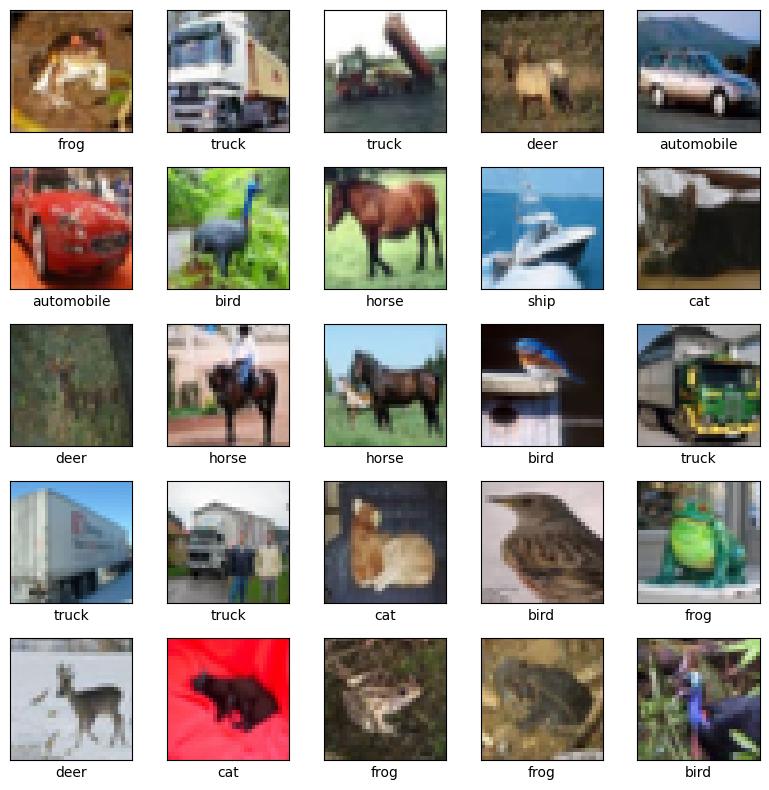

In [15]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 1.3 Visualize Sample Images
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.tight_layout()
plt.show()

## 1.3 Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) and [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument **input_shape** to our first layer.


In [19]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)), layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3,3), activation='relu'), layers.BatchNormalization(), layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3,3), activation='relu'), layers.BatchNormalization(), layers.Dropout(0.5)
])

Now, let's display the architecture of our model.

In [20]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,960 (222.50 KB)

 Trainable params: 56,640 (221.25 KB)

 Non-trainable params: 320 (1.25 KB)

Above, we can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64).

## 1.4 Adding Dense Layers on the top
To complete our model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more **Dense layers** to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [21]:
#Flattens the 3D output to 1D for dense layers.
model.add(layers.Flatten())
#Adds a fully connected layer with 64 neurons and ReLU activation.
model.add(layers.Dense(128, activation='relu'))
#Final layer with 10 neurons (one per class) without activation (logits for loss calculation).
model.add(layers.Dense(10))

Here's the complete architecture of our model.

In [22]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,450 (740.04 KB)

 Trainable params: 189,130 (738.79 KB)

 Non-trainable params: 320 (1.25 KB)

So our (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

## 1.5 Compile and train the model

In [23]:
# Adam is the best among the adaptive optimizers in most of the cases
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# An epoch means training the neural network with all the
# training data for one cycle. Here I use 10 epochs
history = model.fit(train_images, train_labels, epochs=10,validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.3858 - loss: 1.8289 - val_accuracy: 0.4147 - val_loss: 1.8751
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.5977 - loss: 1.1377 - val_accuracy: 0.6160 - val_loss: 1.1055
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.6478 - loss: 0.9915 - val_accuracy: 0.6660 - val_loss: 0.9512
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.6850 - loss: 0.8926 - val_accuracy: 0.6763 - val_loss: 0.9182
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7089 - loss: 0.8213 - val_accuracy: 0.5949 - val_loss: 1.2096
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.7319 - loss: 0.7582 - val_accuracy: 0.7209 - val_loss: 0.8020
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.7501 - loss: 0.7154 - val_accuracy: 0.7235 - val_loss: 0.7919
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7604 -

## 1.6 Evaluate the model

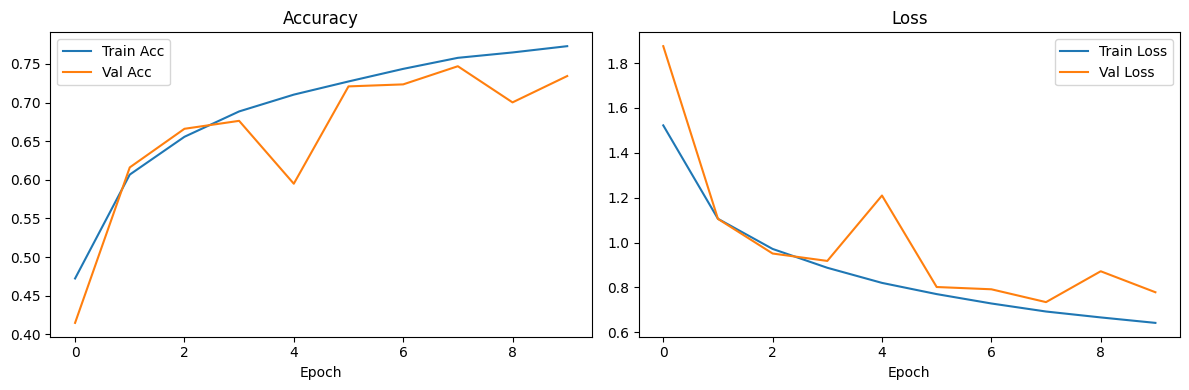

313/313 - 2s - 5ms/step - accuracy: 0.7343 - loss: 0.7787


In [24]:
# 1.8 Plot Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy'); plt.xlabel('Epoch')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss'); plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

# 1.9 Evaluate Model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

In [25]:
print(f"\nTest accuracy: {test_acc:.4f}")


Test accuracy: 0.7343


In [26]:
# 2.0 Classification Report
pred_probs = model.predict(test_images)
pred_labels = np.argmax(pred_probs, axis=1)

print("\nClassification Report:\n")
print(classification_report(test_labels, pred_labels, target_names=class_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Classification Report:

              precision    recall  f1-score   support

    airplane       0.79      0.76      0.77      1000
  automobile       0.75      0.93      0.83      1000
        bird       0.62      0.66      0.64      1000
         cat       0.59      0.56      0.57      1000
        deer       0.76      0.60      0.67      1000
         dog       0.75      0.53      0.62      1000
        frog       0.68      0.87      0.76      1000
       horse       0.81      0.77      0.79      1000
        ship       0.80      0.87      0.83      1000
       truck       0.83      0.81      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



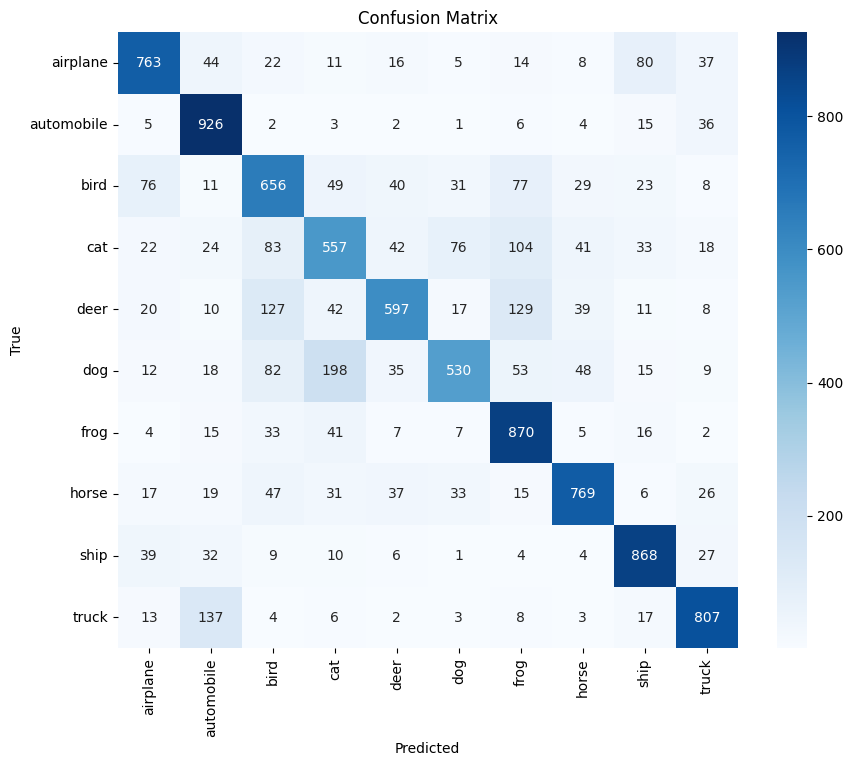

In [27]:
# 2.1 Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_labels, pred_labels), 
            xticklabels=class_names, yticklabels=class_names,
            annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

